# Анализ данных об играх
**Цель:** найти потенциально популярный продукт и успешно спланировать рекламные компании;
 
Для достижения цели необходимо выявить закономерности, определяющие успешность игры. Для этого выполним следующие шаги:
- [Знакомство с данными](#1);
- [Предопработка данных](#2);
- [Исследовательский анализ: нахождение зависимости продаж от разных факторов](#3);
- [Установление портрета пользователя в разных регионах](#4);
- [Проверка гипотез](#5);
- [Вывод](#6).


<a id='1'></a>
## Общая информация
В данных представлена информация об играх: продажи, оценки пользователей и экспертов, жанры и платформы, а также регион.

In [182]:
# загрузка библиотек
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt  
from scipy import stats as st 
import numpy as np
import seaborn as sbn
import warnings

warnings.filterwarnings("ignore")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


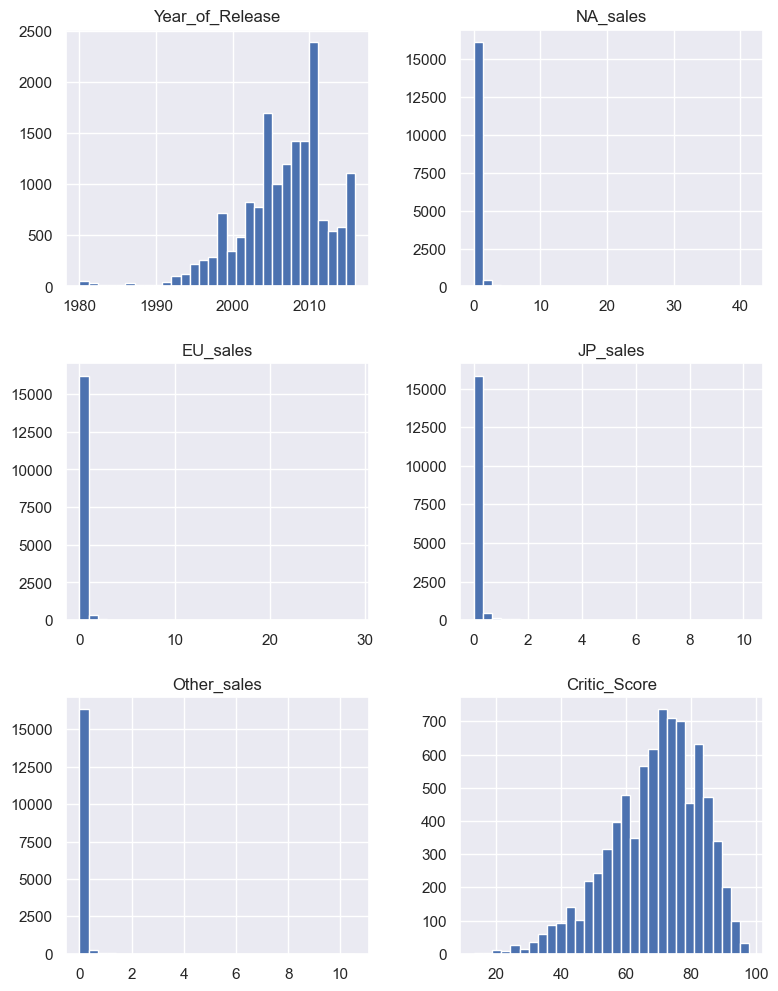

In [221]:
# Импорт и первичное исследование
df = pd.read_csv('games.csv')

df.info()
df.hist(bins=30, figsize=(9,12))
df.head()

**Техническая часть**

In [184]:
# функция для оформления графиков
def plt_design(title='title',
               title_size=18, 
               xlabel='xlabel', 
               ylabel='ylabel',
               fontsize=14, # размер шрифта подписей к осям
               ticks_size=12, # размер шрифта делений на осях
               xrot=0, # наклон подписей делений
               yrot=0,
               ):
    
    plt.title(title, fontsize = title_size)
    plt.xlabel(xlabel, fontsize=fontsize) 
    plt.ylabel(ylabel, fontsize=fontsize)
    plt.xticks(fontsize = ticks_size, rotation=xrot)
    plt.yticks(fontsize = ticks_size, rotation=yrot)
    
    
    return
plt.show();

<a id='2'></a>
## Предобработка данных

### Переименование столбцов

In [185]:
# приведем названия к нижнему регистру
df.columns = df.columns.str.lower()

### Обработка пропусков

Найдем и изучим пропущенные значения в столбцах:

In [186]:
df.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

In [187]:
# функция для визуализации пропусков
def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100) 
            .to_frame() 
            .rename(columns = {0:'space'}) 
            .query('space > 0') 
            .sort_values(by = 'space', ascending = True)
            .plot(kind= 'barh', figsize=(12,3), legend = False, fontsize = 16)
            .set_title('Пропуски' + "\n", fontsize = 22)
        ); 
    except:
        print('пропусков не осталось')
        

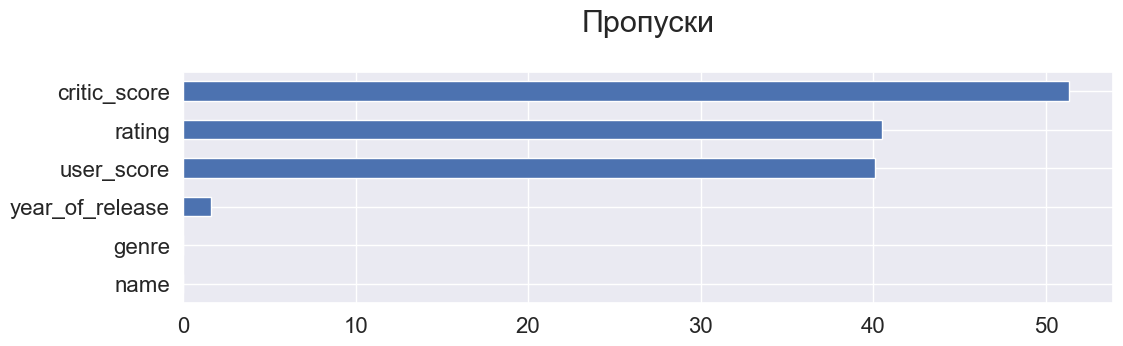

In [188]:
pass_value_barh(df)

Строки с пропусками в колонках 'genre', 'name' и 'year_of_release' можно удалить, т.к. количество значений относительно всего датасета пренебрежимо мало. Что касается остальных колонок - в них пропущено около 50% всех значений, отказаться от них мы не можем. Посмотрим, какие величины там встречаются:

In [189]:
# удаляем строки с нулевыми значениями в колонках 'name', 'genre', 'year_of_release':
df.dropna(subset=['name', 'genre', 'year_of_release'], inplace=True)

In [190]:
for i in ['critic_score', 'user_score', 'rating']:
    print(i, df[i].unique(), '\n')

critic_score [76. nan 82. 80. 89. 58. 87. 91. 61. 97. 95. 77. 88. 83. 94. 93. 85. 86.
 98. 96. 90. 84. 73. 74. 78. 92. 71. 72. 68. 62. 49. 67. 81. 66. 56. 79.
 70. 59. 64. 75. 60. 63. 69. 50. 25. 42. 44. 55. 48. 57. 29. 47. 65. 54.
 20. 53. 37. 38. 33. 52. 30. 32. 43. 45. 51. 40. 46. 39. 34. 41. 36. 31.
 27. 35. 26. 19. 28. 23. 24. 21. 17. 13.] 

user_score ['8' nan '8.3' '8.5' '6.6' '8.4' '8.6' '7.7' '6.3' '7.4' '8.2' '9' '7.9'
 '8.1' '8.7' '7.1' '3.4' '5.3' '4.8' '3.2' '8.9' '6.4' '7.8' '7.5' '2.6'
 '7.2' '9.2' '7' '7.3' '4.3' '7.6' '5.7' '5' '9.1' '6.5' 'tbd' '8.8' '6.9'
 '9.4' '6.8' '6.1' '6.7' '5.4' '4' '4.9' '4.5' '9.3' '6.2' '4.2' '6' '3.7'
 '4.1' '5.8' '5.6' '5.5' '4.4' '4.6' '5.9' '3.9' '3.1' '2.9' '5.2' '3.3'
 '4.7' '5.1' '3.5' '2.5' '1.9' '3' '2.7' '2.2' '2' '9.5' '2.1' '3.6' '2.8'
 '1.8' '3.8' '0' '1.6' '9.6' '2.4' '1.7' '1.1' '0.3' '1.5' '0.7' '1.2'
 '2.3' '0.5' '1.3' '0.2' '0.6' '1.4' '0.9' '1' '9.7'] 

rating ['E' nan 'M' 'T' 'E10+' 'K-A' 'AO' 'EC' 'RP'] 



В столбце 'user_score' встречается значение 'tbd' – заменим его на NaN. 

In [191]:
df['user_score'] = df['user_score'].replace('tbd', np.nan)

Заменять пропущенные значения в столбцах 'critic_score', 'user_score' некорректно, так как в них содержится информация об оценках пользователей/критиков – это не угадать, и поменяв значения, например, на среднее, можно получить ложные выводы. В колонке 'rating' – категории игр. Оставим пропуски без изменений, чтобы не потерять и не исказить данные, т.к. они используются в статистическом анализе, инструменты которого чувствительны к изменениям в данных.

### Преобразование типов


Преобразуем типы данных в столбцах: 'year_of_release', 'user_score' – в числовые значения (int и float соответственно):

In [192]:
df['year_of_release'] = df['year_of_release'].astype('int') 
df['user_score'] = pd.to_numeric(df['user_score'], errors='ignore')


In [193]:
for i in ['year_of_release', 'user_score']:
    print(i, df[i].dtype)

year_of_release int64
user_score float64


### Добавление столбца 

Посчитаем суммарные продажи во всех регионах и запишем их в отдельный столбец:

In [194]:
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']


### Итоги предобработки

- Некоторые значения в столбцах были пропущены. В столбцах 'name', 'genre', 'year_of_release' – количество пропусков незначительно, они (пропуски) были удалены; 
- Были оставлены попуски в столбцах 'critic_score', 'user_score' и 'rating', т.к. пропущено около 50% всех значений, а это значительная часть данных;
- Также пропуски в этих столбцах не заменены на другие значения, т.к. использование искаженных данных может сказаться на результатах статистического анализа, инструменты которого чувствительны к изменениям в данных;
- В колонке с количественными переменными обнаружены категориальные пременные ('tbd' в 'user_score'). Они были заменены на 'NaN', здесь это уместно, потому что 'tbd'='предстоит определить', это по смыслу и есть пропуск. Далее мы будем работать с числовыми значениями этого столбца;
- Типы столбцов 'year_of_release', 'user_score' приведены в числовые (int и float соответственно);
- Был добавлен столбец с обищими мировыми продажами – 'total_sales';
    
</div>

<a id='3'></a>
## Исследовательский анализ

### Количество выпущенных игр в разные годы

Посмотрим, сколько игр выпускалось в разные годы. Для этого построим гистограмму:

Минимальное значение: 1980
Максимальное знаение: 2016


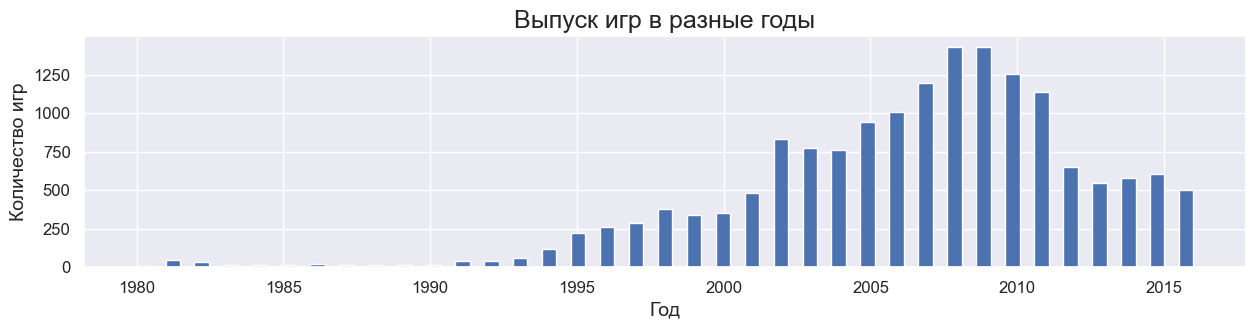

In [195]:
print('Минимальное значение:', df.year_of_release.min())
print('Максимальное знаение:' , df.year_of_release.max())

(df
 .year_of_release.plot.hist(bins=73, 
                            figsize=(15,3), 
                            grid=True
                           )
)

plt_design(title='Выпуск игр в разные годы', 
               xlabel='Год', 
               ylabel='Количество игр');

По графику видно, что выпуск игр с годами изменялся и всегда по-разному:
- в период 1980-1990 – плато, с каждым годом количество выпусков не меняется
- с 1990 по 2008 – стабильный и плавный рост с незначительными отклонениямиот общего тренда
- 2008 год – максимальное количество выпусков 
- после 2008 – резкое снижение выпуска игр, и так до 2012 года
- начиная с 2012 по 2016 – не происходит значительных изменений

### Связь продаж, платформ и даты релиза
Здесь главной целью ставим выбор актуального периода для прогноза на 2017 год. Именно этот период будет интересен далее при исследованиии влияния различных параметров на продажи. Для достижения цели выделим следующие шаги:

- Поиск наиболее успешных в продажах платформ за всё время;
- Распределение продаж по годам для наиболее успешных платформ;
- Выявление характерного срока появления новых и исчезновения старых платформ;
- Выбор актуального периода для прогноза на 2017 год;

Посмотрим, как продаются игры в зависимости от от платформы:

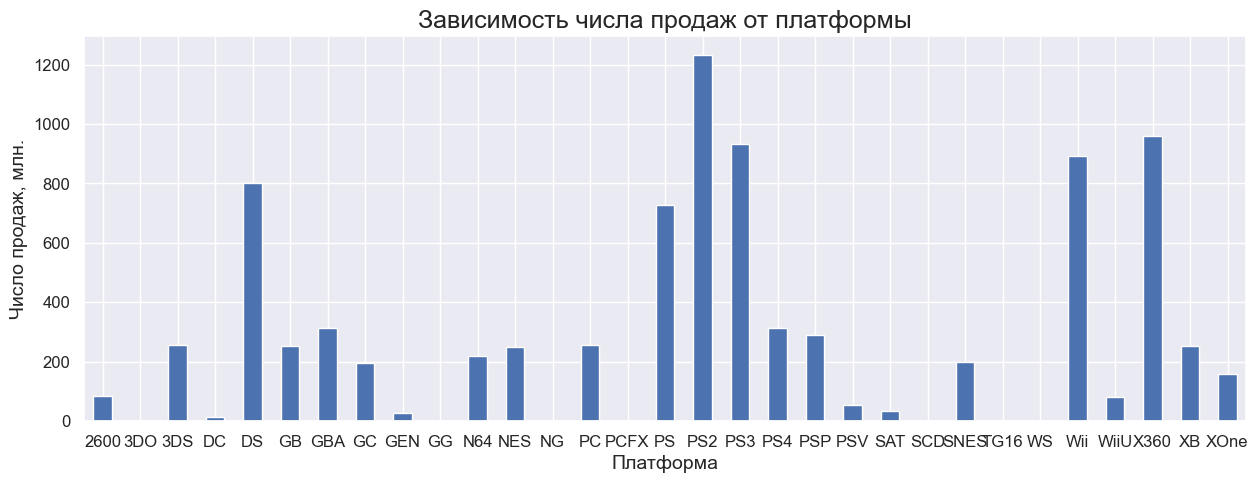

In [196]:
(df.groupby('platform')['total_sales']
 .sum()
 .plot.bar(figsize=(15,5),
           rot=45,
           grid=True
          )
)

plt_design(title='Зависимость числа продаж от платформы', 
               xlabel='Платформа', 
               ylabel='Число продаж, млн.');


Наиболее успешные в продажах платформы за всё время:
- DS
- PS
- PS2
- PS3
- Wii
- X360

Построим распределение продаж по годам для этих платформ, с помощью линейного графика проследим динамику:

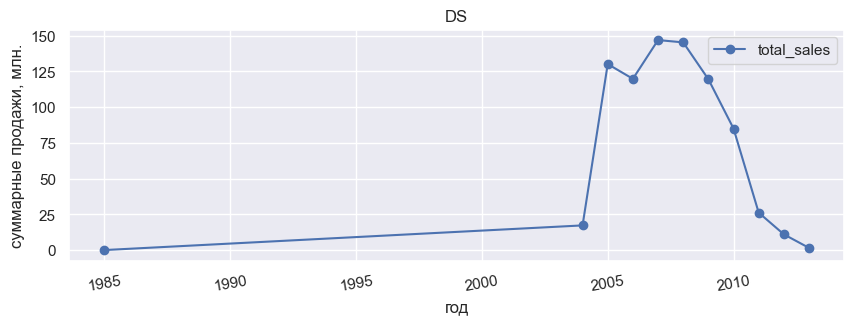

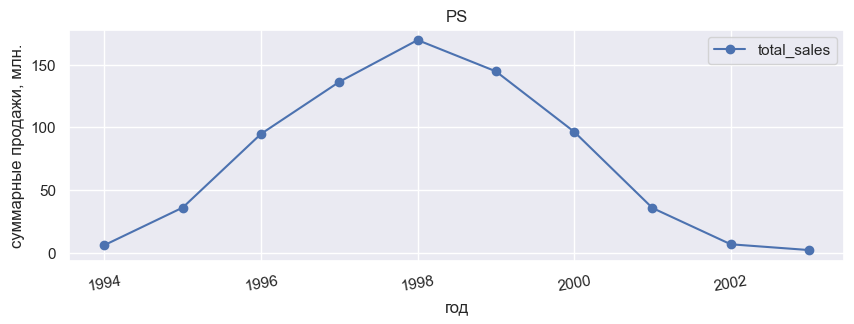

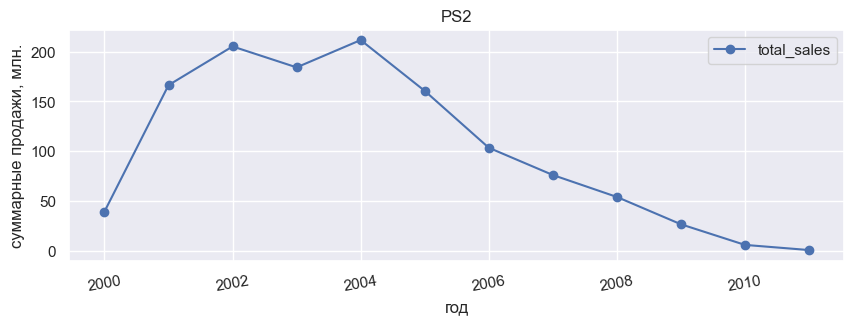

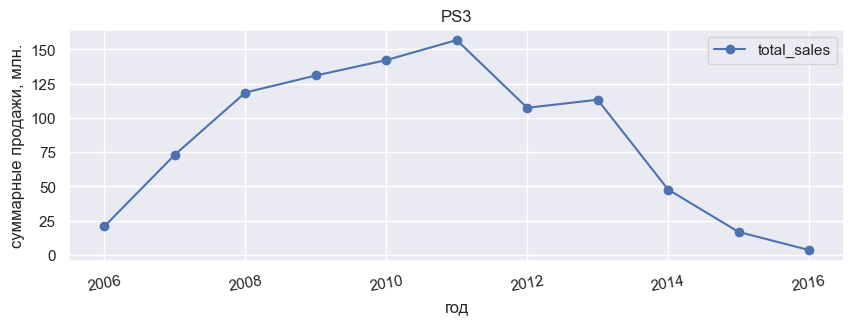

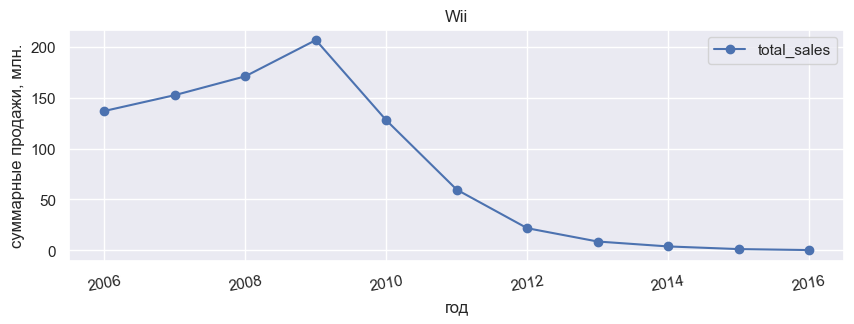

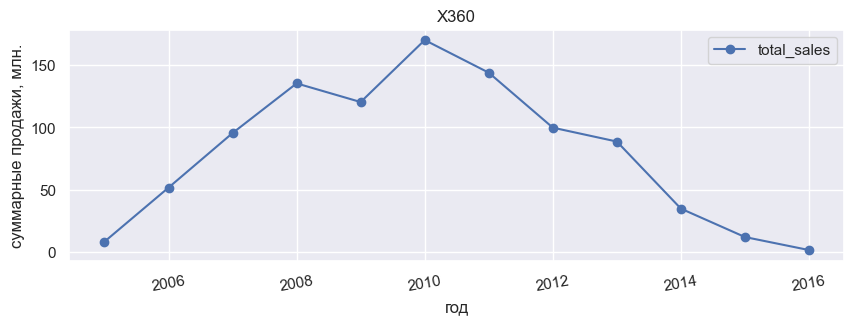

In [197]:
list_platform = ['DS', 'PS', 'PS2', 'PS3', 'Wii', 'X360'] # список успешных платформ

# распределение по годам :
for platform in list_platform:
    (df[df['platform'] == platform]
     .pivot_table(index='year_of_release',values='total_sales',aggfunc='sum')
     .plot(figsize=(10,3),
           style='o-',
           rot=10,
           grid=True,
           xlabel='год',
           ylabel='суммарные продажи, млн.')
    );
    plt.title(platform)

По графикам видно:
- Примерный период "жизни" платформы – около 10 лет;
- Для каждой платформы характерно: сначала количество продаж растет, потом падает;
- Пиковые значения продаж у рассматриваемых платформ приблизительно одинаковы (примерно 150-200);


Интересно отметить пиковые годы продаж для каждой платформы:
- PS – 1998
- PS2 – 2004
- DS – 2007-2008
- Wii – 2009
- X360 – 2010
- PS3 – 2011

По популярности платформы в тот или иной год, можно сделать вывод, что характерный срок появления новых и исчезновения старых платформ менялся со временем. Сначала этот процесс занимал около трех-четырех лет, затем (начиная с 2008) – около одного года.

<b>   
    
Следовательно, чтобы построить прогноз на 2017 год, нужно учитывать полученные результаты:
- "жизнь" платформы равна 10 годам (5 из которых успешны в продажах, а 5 других - занимают рост и спад);
- каждый год появляется новая более успешная в продажах платформа;
- из пункта 3.1 важна разница в количесвте выпусков игр – если мало выпусков, то и продаж мало;

    <br />

### Выбор потенциально прибыльных платформ 

Выбор потенциально прибыльных платформ – основная задача. Для выполнения которой необходимо:

- Проанализировать продажи на разных платформах за выбранный период;
- Построить боксплот для нескольких потенциально прибыльных платформ;

Учитывая полученные выводы, рассмотрим, как менялись продажи у всех платформ за период с **2012 по 2016 год**:

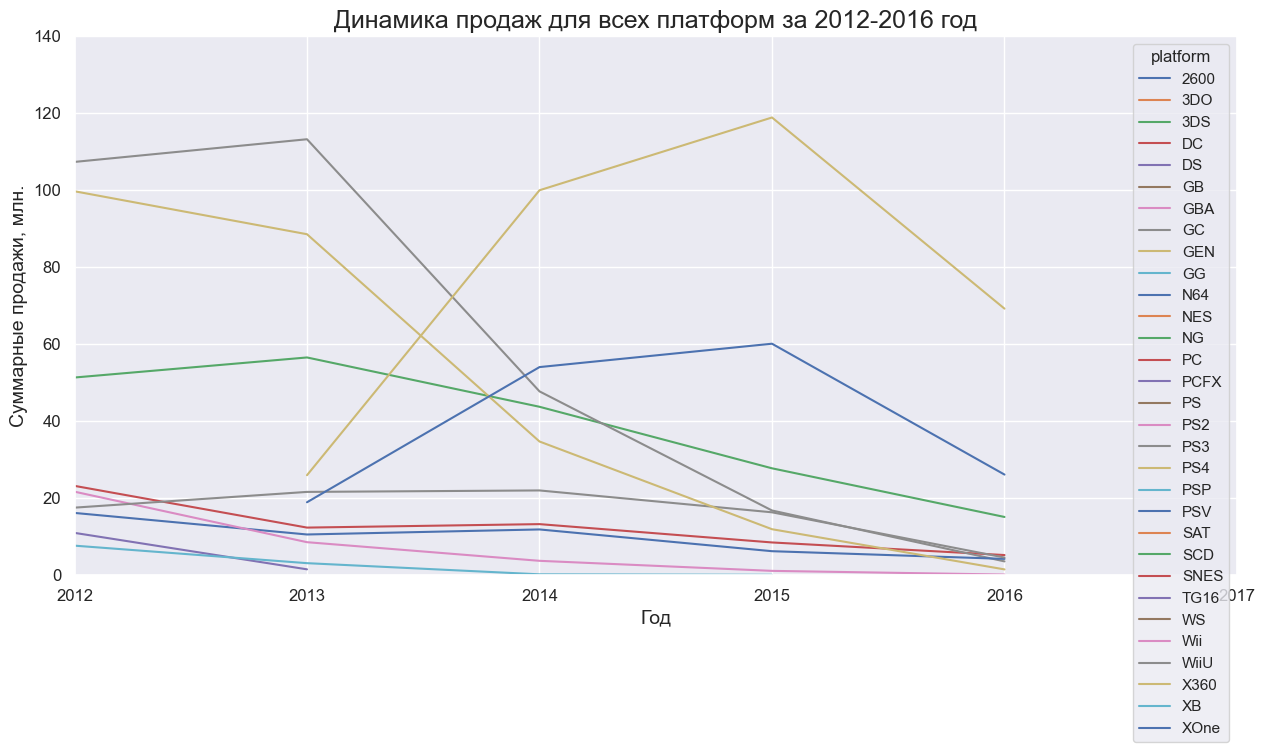

In [198]:
( df
 .pivot_table(index='year_of_release',columns='platform',values='total_sales',aggfunc='sum')
 .plot(figsize=(15,7), 
               rot=10,
               grid=True,
               ylim=[0,140],
               xlim=[2012, 2017]
      )
)

plt_design(title='Динамика продаж для всех платформ за 2012-2016 год', 
               xlabel='Год', 
               ylabel='Суммарные продажи, млн.');

- Число продаж за рассматриваемый период не превышает 120 млн. в год;
- Продажи падают на всех платформах;
- Самые высокие продажы у PS4 (убедимся в этом далее);
- Продажи у платформ: PSP, DS – практически свелись к нулю, учитывать их дальше при анализе не имеет смысла;

In [199]:
df[df['year_of_release'] == 2016]['platform'].unique() # ещё существующие в 2016 году платформы

array(['PS4', '3DS', 'XOne', 'WiiU', 'PS3', 'PC', 'X360', 'PSV', 'Wii'],
      dtype=object)

Посмотрим, какие платформы лидируют по продажам за период 2012-2016 годы:

In [200]:
# дата для актуального периода
actual_df = df[(df['year_of_release'] >= 2012) & (df['platform'] != 'PSP') & (df['platform'] != 'DS')] 

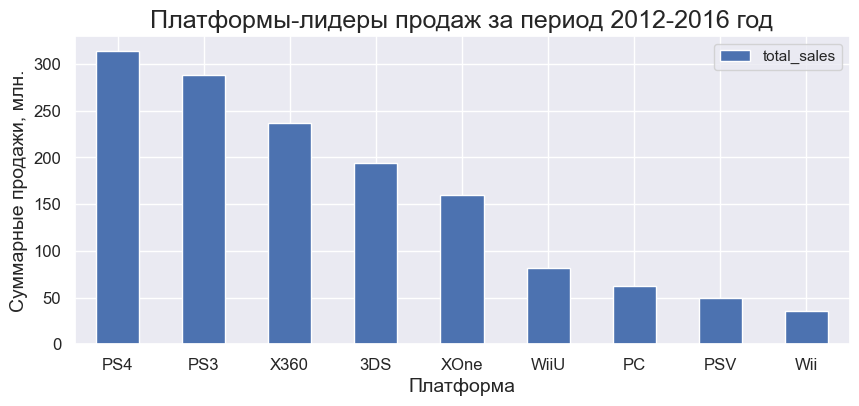

In [201]:
# платформы-лидеры продаж за период 2012-2016 год
(actual_df
 .pivot_table(index='platform',values='total_sales',aggfunc='sum')
 .sort_values(by='total_sales', ascending=False)
 .plot.bar(figsize=(10,4), 
               rot=10, 
               grid=True)    
          )

plt_design(title='Платформы-лидеры продаж за период 2012-2016 год', 
           xlabel='Платформа',
           ylabel='Суммарные продажи, млн.');

In [202]:
(actual_df
 .pivot_table(index='platform',values='total_sales',aggfunc='sum')
 .sort_values(by='total_sales', ascending=False)
)

,total_sales
platform,
PS4,314.14
PS3,288.79
X360,236.54
3DS,194.61
XOne,159.32
WiiU,82.19
PC,62.65
PSV,49.18
Wii,35.37


<b>
    
Потенциально прибыльные платформы: 
- PS4 – около 314 млн.
- PS3 – 288 млн.
- X360 – 236 млн.

<br />

Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам и сравним разбросы. Для этого рассмотрим топ-3 платформ, полученных выше.

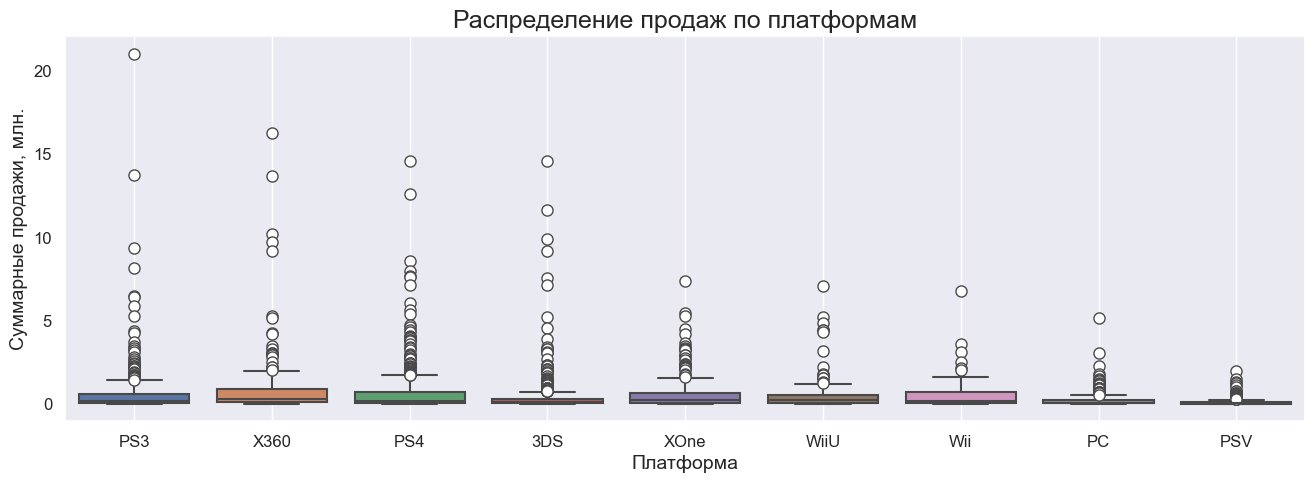

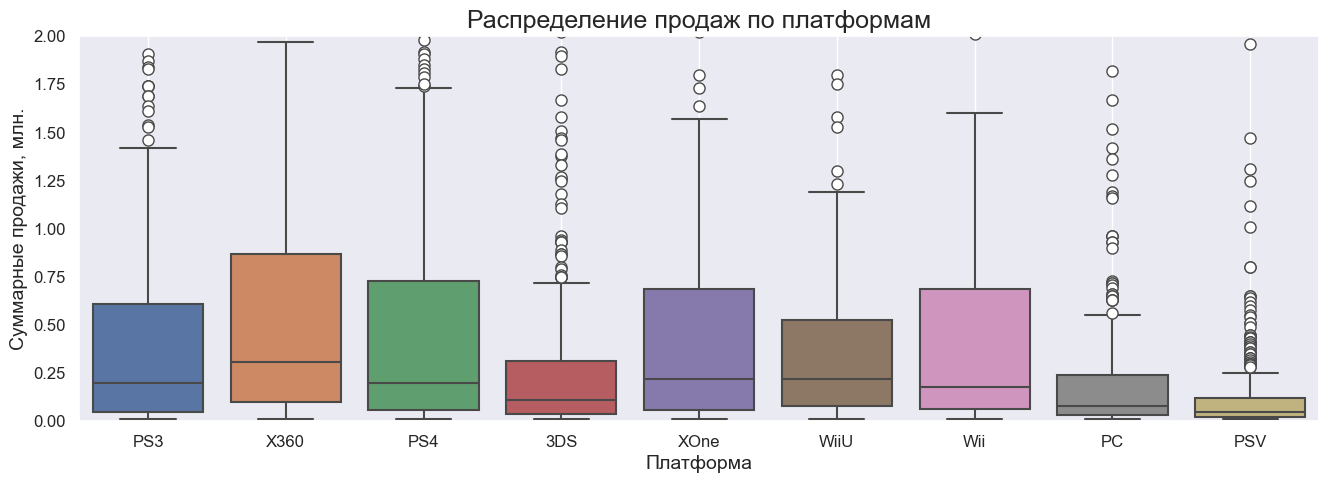

In [203]:
# Сначала построим боксплот для всех актуальных (не только популярных) платформ:

(sbn.boxplot(x=actual_df['platform'], 
             y=actual_df['total_sales'],
             flierprops = dict(marker='o', markerfacecolor='white', markersize=8))
)
plt.grid()
plt_design(title='Распределение продаж по платформам', 
           xlabel='Платформа',
           ylabel='Суммарные продажи, млн.')
plt.show()

# Посмотрим в большем масштабе:  
(sbn.boxplot(x=actual_df['platform'], 
             y=actual_df['total_sales'],
             flierprops = dict(marker='o', markerfacecolor='white', markersize=8)
            )
).set_ylim([0, 2])
plt.grid()
sns.set(rc={'figure.figsize':(15,8)})
plt_design(title='Распределение продаж по платформам', 
           xlabel='Платформа',
           ylabel='Суммарные продажи, млн.')
plt.show();

Сравним для актуальных платформ следующие параметры:

**1) Межквартильный размах** \
  Самый узкий ящик получился у PSV, это говорит о том, что продажи отдельные игр на этой платформе не сильно отличаются друг от друга (в относительно других платформ). Здесь важно учитывать и то, что за рассматриваемый период – эта платформа имеет самые низкие продажи.  Самый широкий ящик у платформы X360 – значения продаж разных игр на этой платформе отличаются. 
  
**2) Выбросы** \
   Наименьшее число выбросов у платформы Wii. Выбросы – это нетипичные наблюдения – какие-то единичные игры продаются так. У этой платформы также мало продаж за актуальный период относительно других платформ. Это и может сказываться на количестве выбросов. 
 
**3) Медианы** \
   Находятся в диапазоне 0,1 – 0,3 млн. продаж. Сильных отклонений у всех платформ относительно друг друга не видно.
   
Посмотрим поближе на лидирующие по продажам платформы и проанализируем их показатели отдельно:

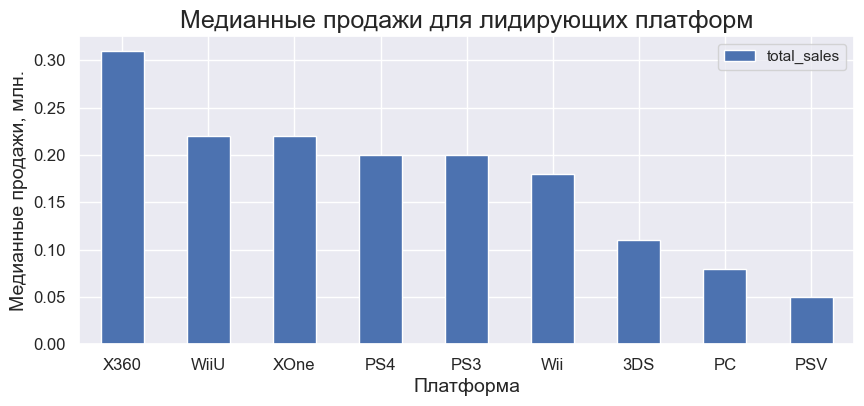

In [204]:
(actual_df
 .pivot_table(index='platform',values='total_sales',aggfunc='median')
 .sort_values(by='total_sales', ascending=False)
 .plot.bar(figsize=(10,4), 
               rot=10, 
               grid=True  
          )
)

plt_design(title='Медианные продажи для лидирующих платформ', 
           xlabel='Платформа',
           ylabel='Медианные продажи, млн.');

PS4
count    392.000000
mean       0.801378
std        1.609456
min        0.010000
25%        0.060000
50%        0.200000
75%        0.730000
max       14.630000
Name: total_sales, dtype: float64


PS3
count    493.000000
mean       0.585781
std        1.462855
min        0.010000
25%        0.050000
50%        0.200000
75%        0.610000
max       21.050000
Name: total_sales, dtype: float64


X360
count    292.000000
mean       0.810068
std        1.712069
min        0.010000
25%        0.100000
50%        0.310000
75%        0.870000
max       16.270000
Name: total_sales, dtype: float64




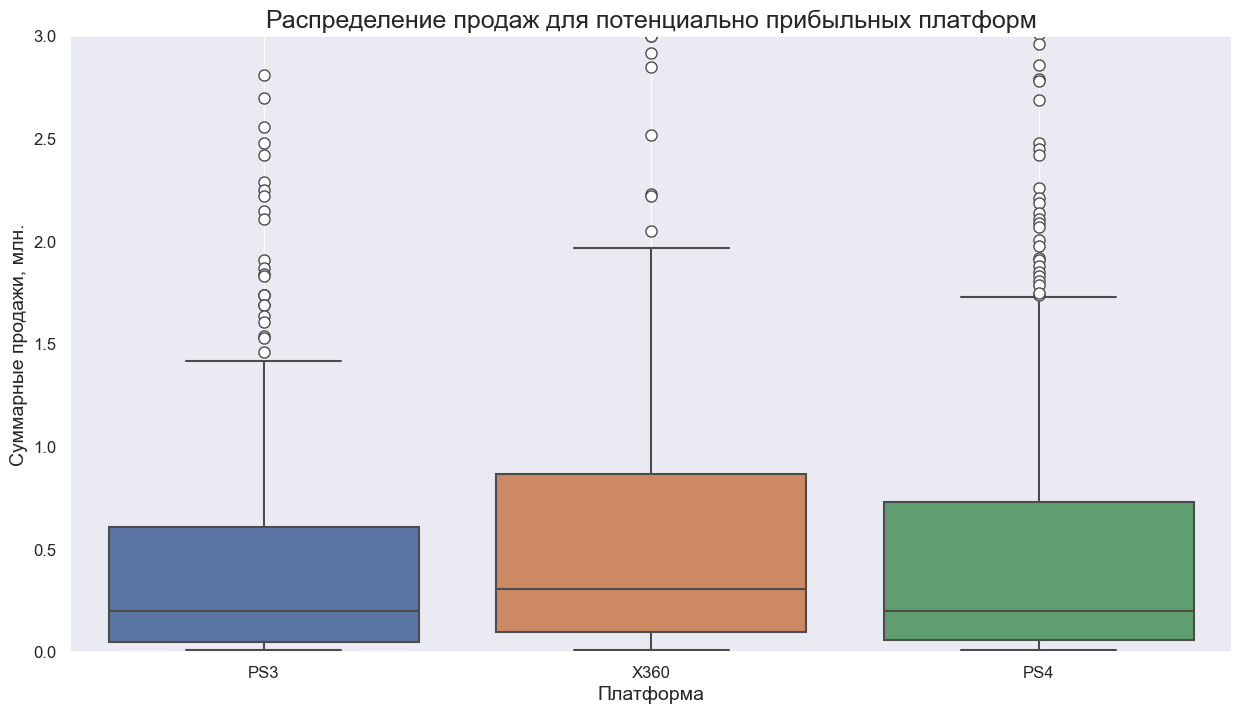

In [205]:
# интересющие платформы и период:
data = actual_df.query('((platform == "PS4" or platform == "PS3" or platform == "X360") and year_of_release >= 2012)')

# построение боксплота:
(sbn.boxplot(x=data['platform'], 
             y=data['total_sales'],
             flierprops = dict(marker='o', markerfacecolor='white', markersize=8)) #редактирование выбросов
    .set_ylim([0, 3])
)
plt.grid()
plt_design(title='Распределение продаж для потенциально прибыльных платформ', 
           xlabel='Платформа',
           ylabel='Суммарные продажи, млн.')

# Получим квартили, медиану и т.д.:
for platform in ['PS4','PS3','X360']:
    print(platform)
    print(df[(df['platform'] == platform) & (df['year_of_release'] >= 2012)]['total_sales']
          .describe())
    print('\n');

Анализ боксплотов для потенциально прибыльных платтформ:

**1) Межквартильный размах** \
  Самый узкий ящик получился у PS3, это говорит о том, что отдельные игры на этой платформе по показателю продаж близки друг к другу, то есть отдельные игры продаются примерно одинаково. 50% всех значений сфокусированно в диапазоне до примерно 0,6 млн. – в диапазоне меньшем, чем у остальных платформ (X360 – до 0,9;  и PS4 – до 0,7). Самый широкий ящик получился у платформы X360. 
  
**2) Выбросы** \
   Нетипичные наблюдения – какие-то единичные игры продаются так. По полученным графикам видно, что выбросов больше у PS4, меньше всего – у X360.
 
**3) Медианы** \
   X360 – 0,3 млн.; PS3 – 0,2 млн.; PS4 – 0,2 млн.; значения практически не отличаются. Половина всех игр продаётся хуже, чем это медианное значение, а другая – успешнее.

### Корреляция отзывов и продаж

Выясним, как влияют на продажи отзывы пользователей и критиков. Для этого произведем следующие шаги: 

- Построение диаграммы рассеяния (продажи-отзывы) для одной популярной платформы;
- Подсчёт корреляции (продажи-отзывы) для одной популярной платформы;
- Сравнение полученных выводов для разных платформ; 

С помощью диаграммы рассеяния посмотрим, как оценки пользователей влияют на продажи самой успешной за рассматриваемый период платформы PS4:

In [206]:
# Написание функции построения графика для определенной платформы и нахождения корреляции:
def scatter_corr(data, platform_name):
    (data[data['platform'] == platform_name]
        .plot(kind='scatter',
              y='total_sales' , 
              x='user_score',
              xlabel='Оценки пользователей', 
              ylabel='Суммарные продажи, млн.',
              alpha=0.5, 
              subplots=True, 
              figsize=(10,5), 
              c = 'b')
    )
    plt.title('Диаграмма рассеяния: отзывы пользователей — продажи', fontsize = 16);

    # зависимость продаж от отзывов критиков – внутри функции и это тоже:
    (data[data['platform'] == platform_name]
        .plot(kind='scatter',
              y='total_sales' , 
              x='critic_score',
              xlabel='Оценки критиков', 
              ylabel='Суммарные продажи, млн.',
              alpha=0.5, 
              subplots=True, 
              figsize=(10,5), 
              c = 'orange'
             )
    )
    plt.title('Диаграмма рассеяния: отзывы критиков — продажи', fontsize = 16);

    # коэффициент корреляции – тоже важно, чтобы каждый раз не копировать:
    print(f"Корреляция – отзывы пользователей – продажи: {data[data['platform'] == platform_name]['user_score'].corr(data[data['platform'] == platform_name]['total_sales'])}")
    print(f"Корреляция – отзывы критиков – продажи: {data[data['platform'] == platform_name]['critic_score'].corr(data[data['platform'] == platform_name]['total_sales'])}")
    
  

Корреляция – отзывы пользователей – продажи: -0.031957110204556424
Корреляция – отзывы критиков – продажи: 0.40656790206178095


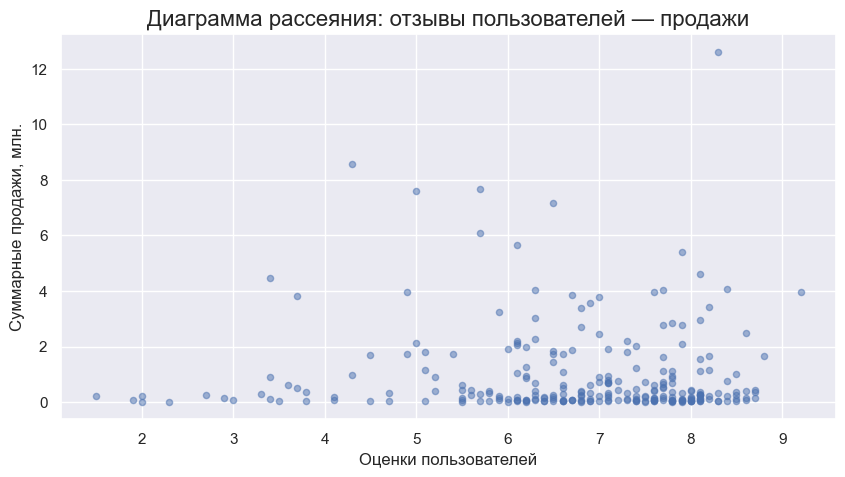

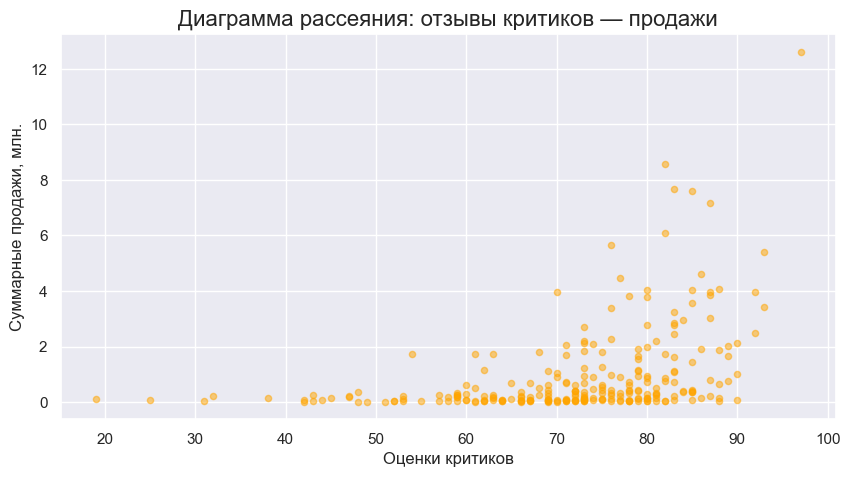

In [207]:
# PS4:
scatter_corr(actual_df, 'PS4')

- Отзывы пользователей не влияют на суммарные продажи (коэффициет корреляции – -0,03)
- Отзывы критиков незначительно влияют на суммарные продажи (корреляция умеренная – 0,41)

Построим диаграммы рассеяния для других топовых за тот период платформ (3DS и XOne) и соотнесем полученные выводы.


<b> 3DS:<br />

Корреляция – отзывы пользователей – продажи: 0.19758263411038599
Корреляция – отзывы критиков – продажи: 0.3208028695360785


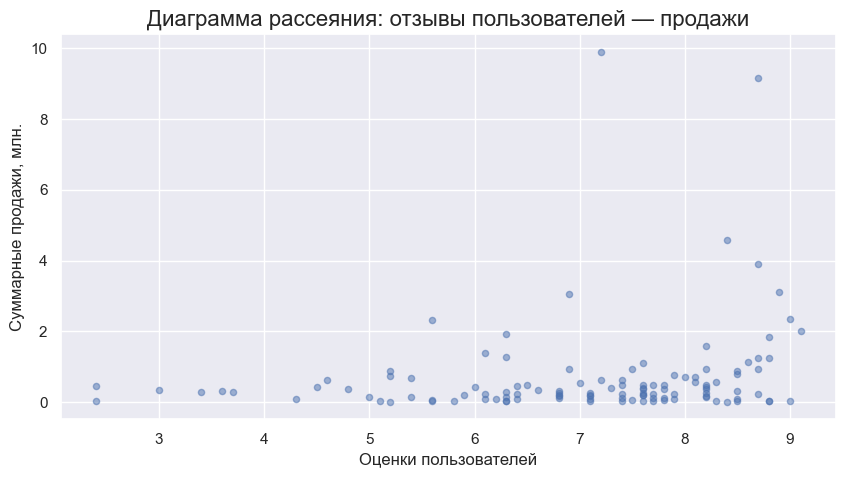

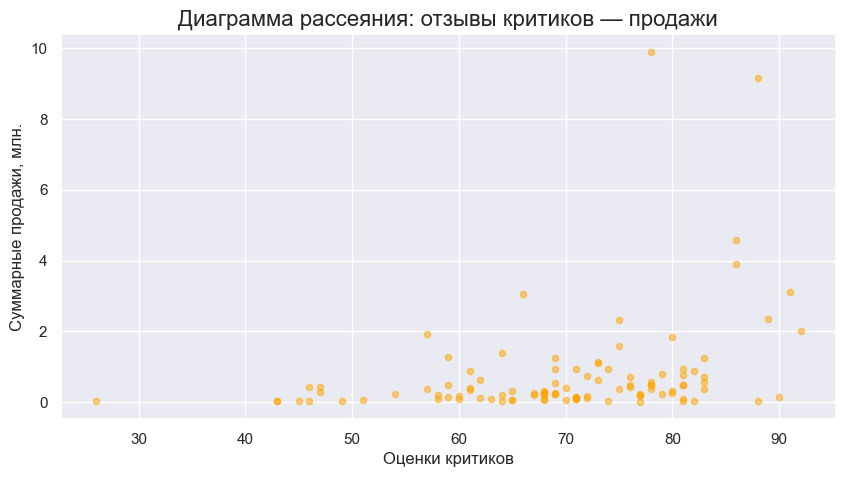

In [208]:
# 3DS
scatter_corr(actual_df, '3DS')

- Отзывы пользователей слабо влияют на суммарные продажи (коэффициет корреляции – 0,22)
- Отзывы критиков незначительно влияют на суммарные продажи (корреляция слабая – 0,35 )

<b> XOne:<br />

Корреляция – отзывы пользователей – продажи: -0.06892505328279414
Корреляция – отзывы критиков – продажи: 0.4169983280084017


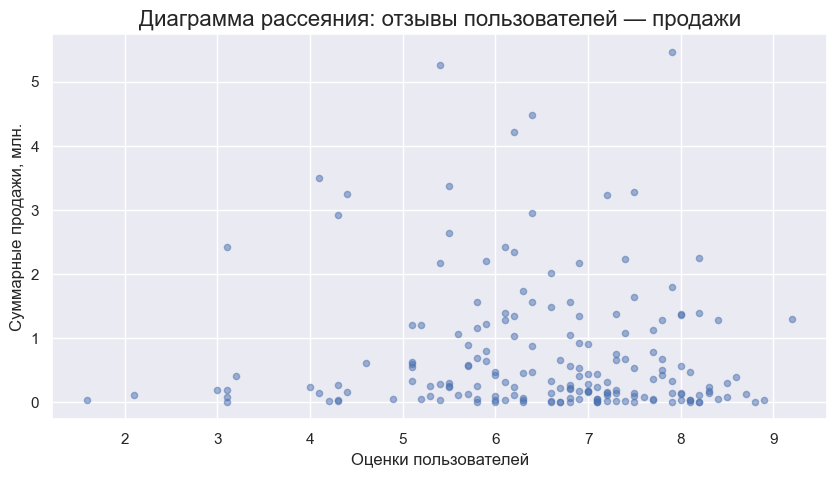

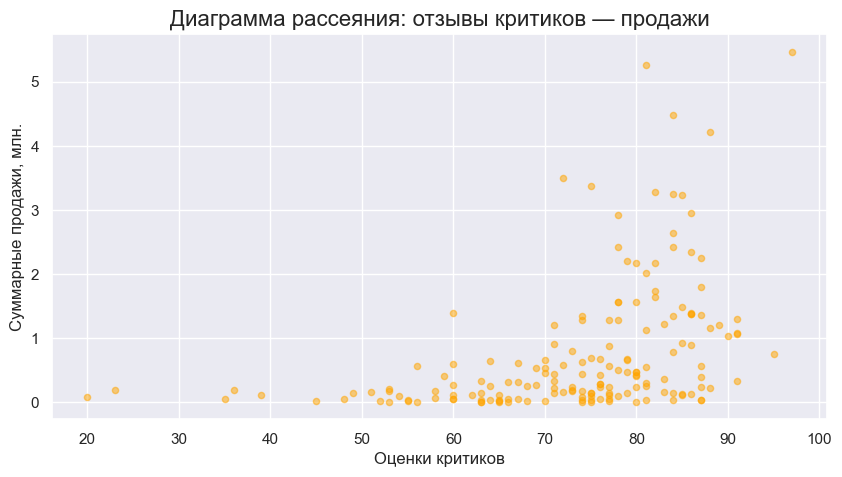

In [209]:
# XOne
scatter_corr(actual_df, 'XOne')

- Отзывы пользователей не влияют на суммарные продажи (коэффициет корреляции – -0,06)
- Отзывы критиков незначительно влияют на суммарные продажи (корреляция умеренная – 0,42)

Полученные по трём платформам (наиболее успешным в продажах за 2012-2016 годы) выводы говорят о том, что связи между продажами и оценками пользователей нет. В то же время оценки критиков влияют на продажи, но незначительно. 

### Влияние жанров игр на продажи

В данном пункте выясним, как продажи зависят от жанра игр, для этого:

- Получим общее распределение игр по жанрам;
- Опишем самые прибыльные жанры;
- Выделим жанры с высокими и низкими продажами;

Посмотрим на общее количественное распределение игр по жанрам, для этого построим гистограмму:

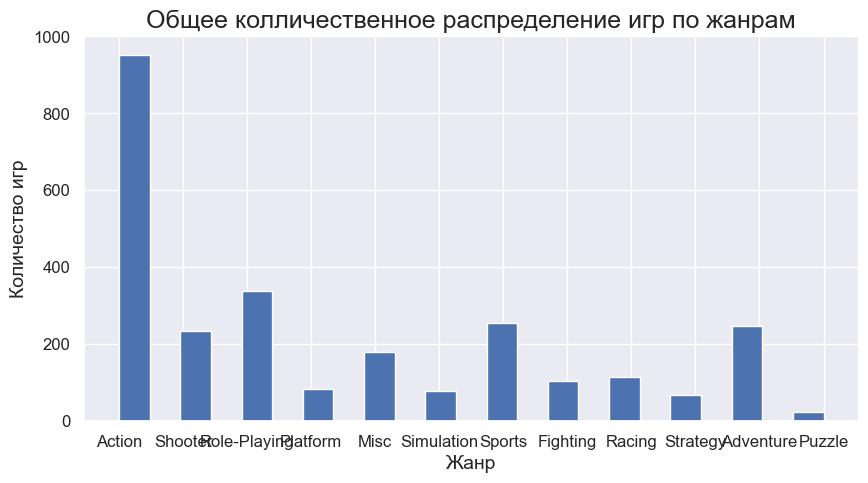

In [210]:
(actual_df['genre'].hist(bins=23,
                         figsize=(10,5),
                         xrot=30
                        )                   
 .set_xlabel('жанры')
)

plt_design(title='Общее колличественное распределение игр по жанрам', 
           xlabel='Жанр',
           ylabel='Количество игр');

Из гистограммы видно:
- Наиболее встречающиеся жанры (в пордке убывания): Action, Role-Playing, Adventure;
- Наименее встречающиеся жанры (в пордке убывания): Platform, Simulation, Stratagy, Puzzle;

Построим боксплоты, чтобы посмотреть на распределение продаж игр по каждому отдельному жанру:

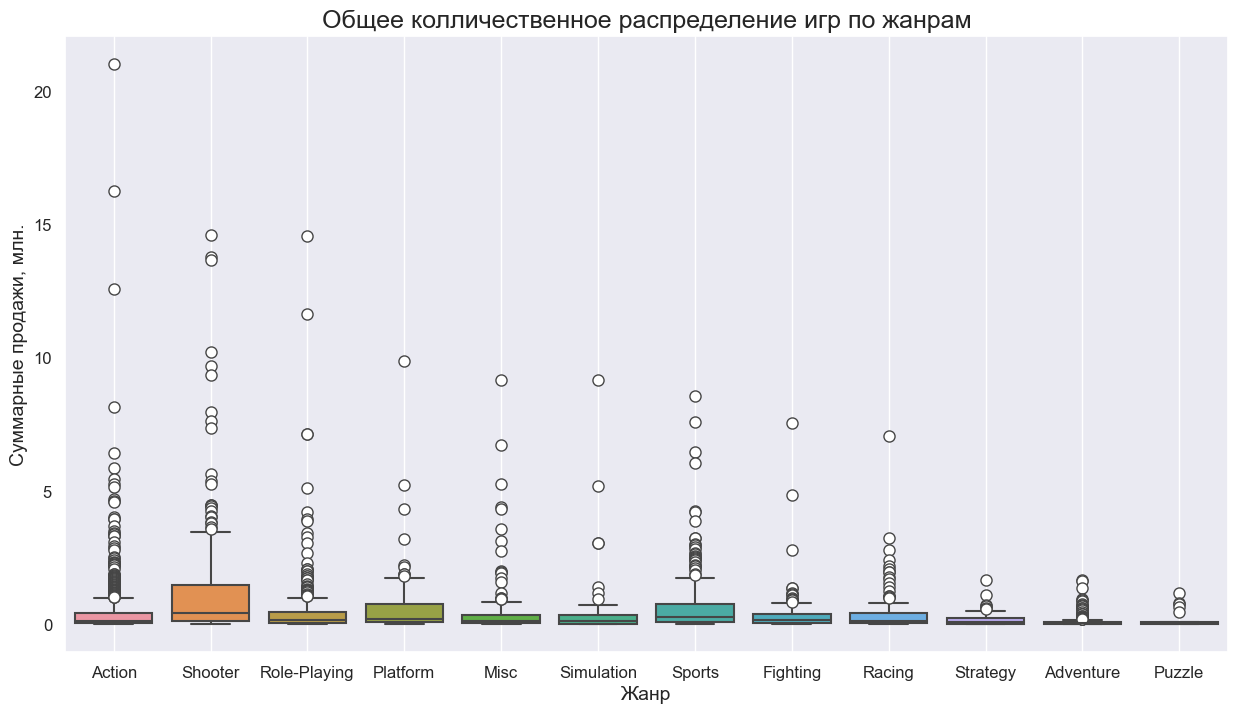

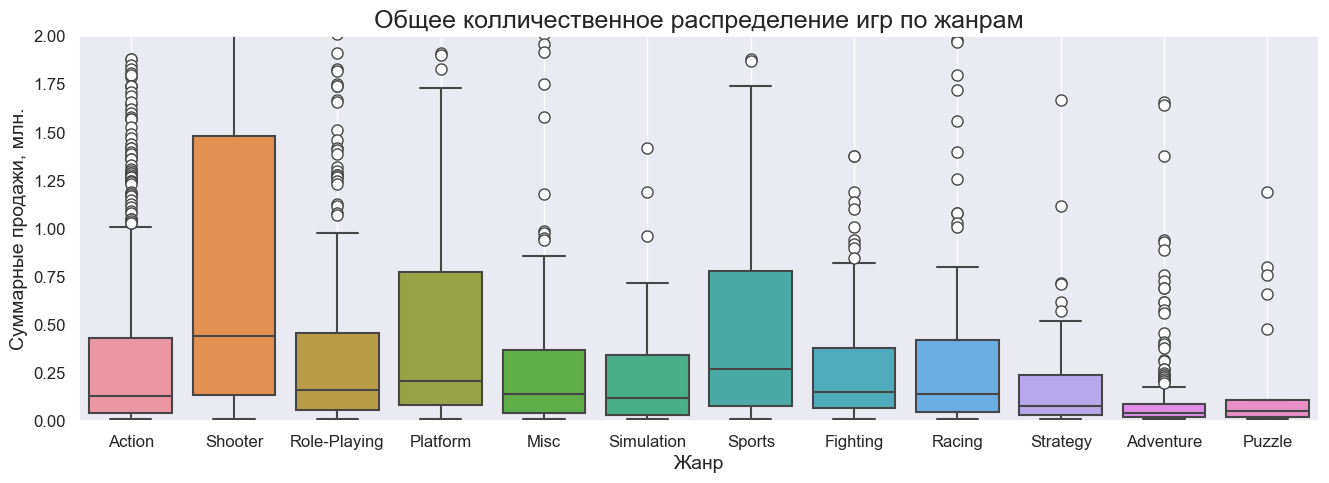

In [211]:
# after_the_review_1
(sbn.boxplot(x=actual_df['genre'], 
             y=actual_df['total_sales'],
             flierprops = dict(marker='o', markerfacecolor='white', markersize=8))
)
plt.grid()
sns.set(rc={'figure.figsize':(16,5)})
plt_design(title='Общее колличественное распределение игр по жанрам', 
           xlabel='Жанр',
           ylabel='Суммарные продажи, млн.')
plt.show()

(sbn.boxplot(x=actual_df['genre'], 
             y=actual_df['total_sales'],
             flierprops = dict(marker='o', markerfacecolor='white', markersize=8)
            )
).set_ylim([0, 2])
plt.grid()
sns.set(rc={'figure.figsize':(16,5)})

plt_design(title='Общее колличественное распределение игр по жанрам', 
           xlabel='Жанр',
           ylabel='Суммарные продажи, млн.')
plt.show();

- Самый широкий ящик у 'Shooter' – то есть 50% игр этого жанра продаются количеством от 0,2 до 1,5 млн., т.е. большем, чем у остальных; самый узкий – 'Advanture';
- Зздесь интересно отметить, что есть выбросы, и их немало. Выбросы – это успех какой-то определенной игры в этом жанре, а не самого жанра. По этой причине далее в анализе стоит учитывать не просто суммарные продажи, а медиану продаж (это значение устойчиво к выбросам);
- Медианные значения рассмотрим на следующем графике;

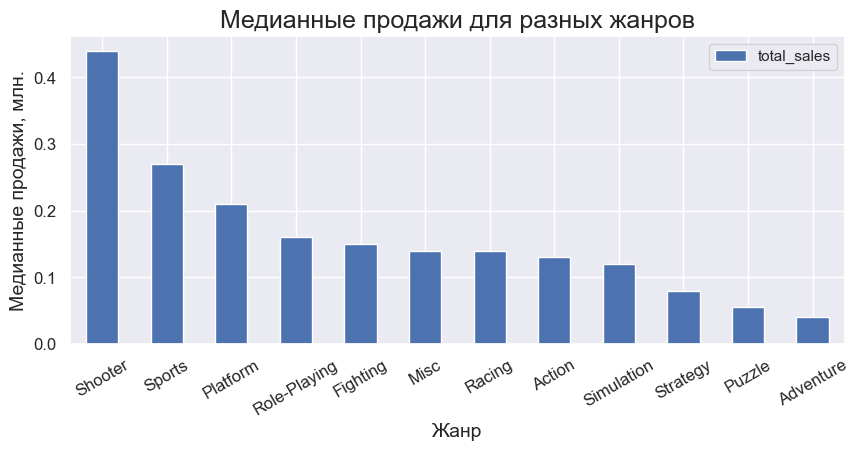

In [212]:
(actual_df
 .pivot_table(index='genre',values='total_sales',aggfunc='median')
 .sort_values(by='total_sales', ascending = False)
 .plot.bar(figsize=(10,4), 
               rot=30, 
               grid=True
          )    
)

plt_design(title='Медианные продажи для разных жанров', 
           xlabel='Жанр',
           ylabel='Медианные продажи, млн.',
           xrot=30
          );

- Топ-3 самых прибыльных жанров (в порядке убывания) – Shooter, Sports, Platform;
- Жанры с наименьшими показателями продаж: Stratagy, Puzzle, Advanture;

### Итоги исследовательского анализа
    
- Мы проанализировали количество выпущенных игр в разные годы и установили, что со временем общее количесвто выпусков менялось. Это привело к необходимости выбрать актуальный период для дальнейшего анализа и прогноза на 2017 год;
- Также со временем менялась популярность тех или иных платформ. Для отдельных платформ за все годы мы получили время развития, успеха и спада этих платформ по количествау продаж. Опираясь на это, мы выбрали актуальный период 2012-2016 годы;
- Мы рассмотрели, какие платформы работали в выбранный период. Некоторые платформы уже не существовали к 2016, брать их в анализ не имело смыла. С помощью боксполотов сравнили выбросы, межквартильный размах, медианные показатели продаж всех актуальных платформ. Выделили лидирующие по суммарным продажам платформы: PS4, PS3, X360.
- С помощью графиков рассеяния увидели, как связаны оценки пользователей и критиков с суммарными продажами игр. Влияние отзывов на продажи: от пользователей – не установлено, от критиоков – незначительно;
- Сравнение медианных продаж каждого жанра помогло определить успешные жанры: Shooter, Sports, Platform. Жанры с наименьшими показателями продаж: Stratagy, Puzzle, Advanture;



<a id='4'></a>
##  Портрет пользователя разных регионов 
Определим портрет типичного пользователя для каждого из регионов: Северной Америки, Европы и Японии. Для этого выполним следующие шаги:
- Найдем топ-5 платформ для каждого региона, и сравним доли в продажах между регионами;
- Найдем топ-5 жанров для каждого региона;
- Выясним, влияет ли рейтинг ESRB на продажи в отдельном регионе;

### Топ-5 платформ. Различия в долях продаж

In [213]:
# data = actual_df 
# parameter - рассматриваемый параметр: или платформа, или жанр;

def region_pie(data, parameter):
    fig, axs = plt.subplots(1,3)
    region_sales_list = ['na_sales', 'eu_sales', 'jp_sales']
    for i in range(3):
        data_pie = (data
                    .groupby(parameter)[region_sales_list[i]]
                    .sum()  
                    .reset_index()
                    .sort_values(region_sales_list[i], ascending=False, ignore_index=True)
                    .head(5)
                   )
    
        data_pie = data_pie.append({parameter:'Other', 
                                    region_sales_list[i]:data[region_sales_list[i]].sum() - data_pie[region_sales_list[i]].sum()
                                   }, 
                                   ignore_index=True
                                  )
        axs[i].pie(data_pie[region_sales_list[i]], labels=data_pie[parameter],autopct='%1.1f%%')
    
        axs[i].set_title(data_pie.columns[1].split(' ')[0].upper())

    plt.show()
    

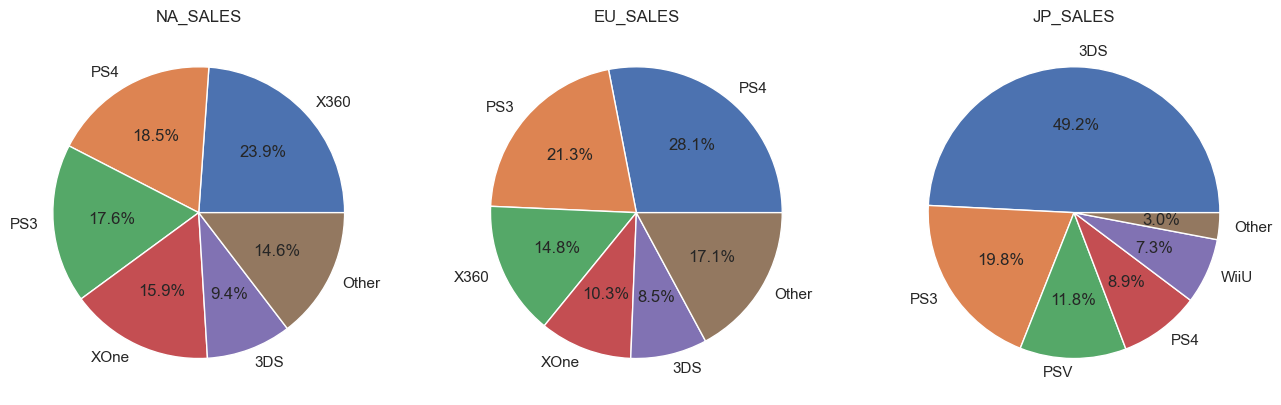

In [214]:
# применим функцию для 'platform':
region_pie(actual_df, 'platform')

**Топ-5 платформ** 
- в Северной Америки:
X360(23,9%), PS4(18,5%), PS3(17,6%), XOne(15,9%), 3DS(9,4%); значения "Other" занимают 14,4% – это пропуски;

- в Европе:
PS4(28,1%), PS3(21,3%), X360(14,8%), XOne(10,3%), 3DS(8,5%); "Other" – 17,1%

- в Японии:
3DS(49,2%), PS3(19,8%), PSV(11,8%), PS4(8,9%), WiiU(7,3%); "Other" – 3%

### Топ-5 жанров

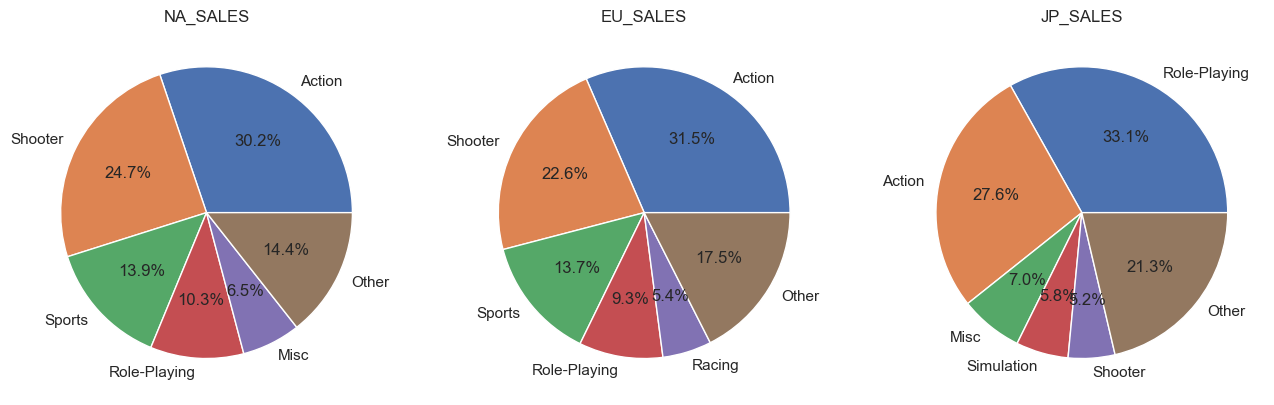

In [215]:
# применим функцию для 'genre':
region_pie(actual_df, 'genre')

**Топ-5 жанров** 
- в Северной Америки: Action (30,2%), Shooter(24,7%), Sports(13,9%), Role-Playing(10,3%), Misk(6,5%); значения "Other" занимают 14,4% – это неуказанные значения;
- в Европе: Action(31,5%), Shooter(22,6%), Sports(13,7%), Role_playing(9,3%), Racing(5,4%); "Other" – 17,5%;
- в Японии: Role_playing(33,1%), Action(27,6%), Misc(7%), Simulation(5,8%), Shooter(5,2%); "Other" – 21,3%;

Здесь интересно отметить, что доли тех или иных жанров СА и Европе – почти не отличаются.

### Рейтинг ESRB и продажи

Описание рейтингов: \
E – для всех; \
E+10 – для всех старше 10 лет; \
M – для взрослых, старше 17; \
T – подростковая, подходит для лиц старше 13 лет; \
Other – здесь это пропущенные значения;

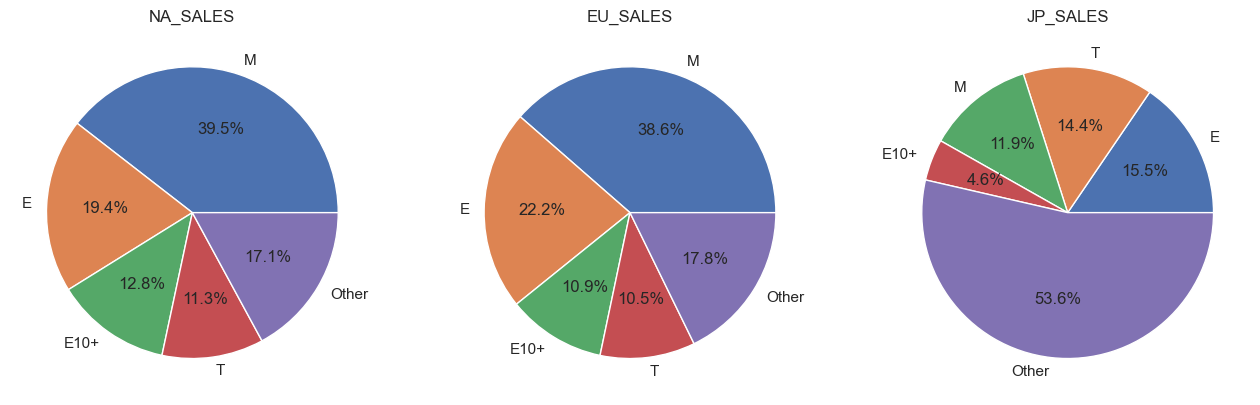

In [216]:
# применим функцию для 'rating':
region_pie(actual_df, 'rating')

- В СА самый продающийся рейтинг – M (почти 40%); самые неуспешные в продажах – T(11%);
- В Европе самый продающийся – M (38,6%); самые неуспешные в продажах – T(10,5%); 
- В Японии 53,6% – это пропущенные значения. Из тех жанров, что точно известны – самый продающийся – E (15,5%); самые неуспешные в продажах – E10+(4,6%);
- Зависимость продаж от рейтинга в Северной Америке и Европе – схожи: показатели продаж не сильно отличаются друг от друга. 

Так же, как и в предыдущем сравнении, отметим, что доли рейтингов в СА и Европе – почти не отличаются.

<a id='5'></a>
## Проверка гипотез
### Проверка первой гипотезы
Сформулируем и проверим гипотезы.
- **$H_0$:** Средние пользовательские рейтинги платформ Xbox One и PC одинаковые; 
- **$H_1$:** Разница между средними пользовательскими рейтингами платформ Xbox One и PC существенна.

In [217]:
# поставим"заглушку" в столбце "user_score" и учтем это далее в условии
# запишем в переменную условие про актуальный период :
df['user_score'] = df['user_score'].fillna(999)
actual_df = df[(df['year_of_release'] >= 2012) & (df['user_score'] != 999) & (df['platform'] != 'PSP') & (df['platform'] != 'DS')]

# results = вызов метода для проверки гипотезы
results = st.ttest_ind(
    actual_df[actual_df['platform'] =='XOne']['user_score'],
    actual_df[actual_df['platform'] =='PC']['user_score'],
    equal_var=False
)

alpha = 0.05 # значение уровня значимости

print('p-значение: ',results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.')

p-значение:  0.5489537965134912
Не получилось отвергнуть нулевую гипотезу: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.


p-value=0,55 – достаточно высокий показатель. Статистически достоверные различия не обнаружены.

### Проверка второй гипотезы
Сформулируем и проверим гипотезы.
- **$H_0$:** Средние пользовательские рейтинги жанров – Action и Sports – равны;
- **$H_1$:** Средние пользовательские рейтинги жанров – Action и Sports – разные.

In [218]:
# results = вызов метода для проверки гипотезы
results = st.ttest_ind(
    actual_df[actual_df['genre'] =='Action']['user_score'],
    actual_df[actual_df['genre'] =='Sports']['user_score'],
    equal_var=False
)

alpha = 0.05 # значение уровня значимости

print('p-значение: ',results.pvalue)
if results.pvalue < alpha:
    print('Пользовательские рейтинги жанров – Action и Sports – разные') 
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение:  5.161357435438797e-20
Пользовательские рейтинги жанров – Action и Sports – разные


Получили p-value=5 на 10 в -20 степени. Это говорит о том, что разница между этими значениями (средними пользовательскими оценками для жанров Action и Sports) достаточно велика, то есть вероятность её получить случайно очень низка.

<a id='6'></a>
## Вывод

В начале работы мы выдвинули **цель: найти потенциально популярный продукт, чтобы успешно спланировать рекламные компании.**

Учитывая распределение выпусков игр в разные годы, продолжительность "успеха" каждой платформы, исчезновение-появление новых платформ, мы выыбрали **актуальный период** для анализа: 2012–2016 годы. 

Исследовательский анализ показал, как разные факторы влияют на продажи игр: 
1) Потенциально прибыльные платформы в 2017: PS4, PS3, X360, 3DS и XOne;

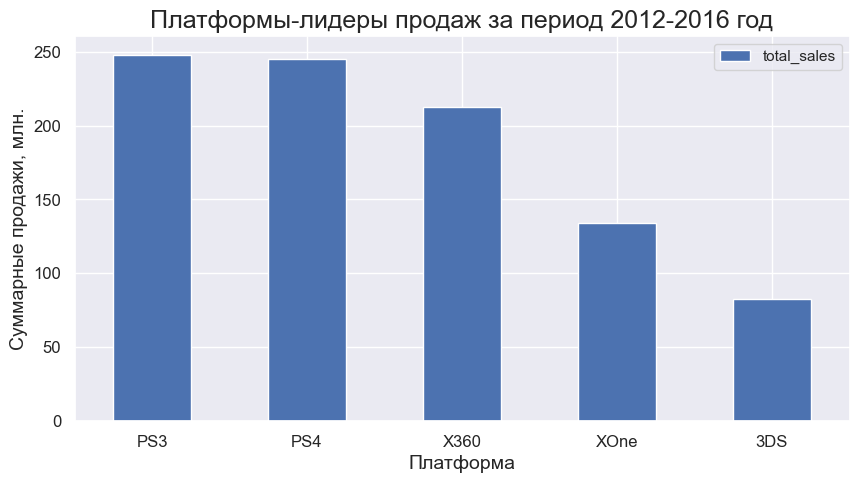

In [219]:
# платформы-лидеры продаж за период 2012-2016 год

(actual_df
 .pivot_table(index='platform',values='total_sales',aggfunc='sum')
 .sort_values(by='total_sales', ascending=False)
 .head(5)
 .plot.bar(figsize=(10,5), 
               rot=10, 
               grid=True)  
)

plt_design(title='Платформы-лидеры продаж за период 2012-2016 год', 
           xlabel='Платформа',
           ylabel='Суммарные продажи, млн.');

2) Отзывы пользователей не влияют на продажи игр, отзывы критиков влияют на продажи слабо; 
3) Наиболее продаваемые жанры: Shooter, Sports, Platform, Role_playing, Racing; 

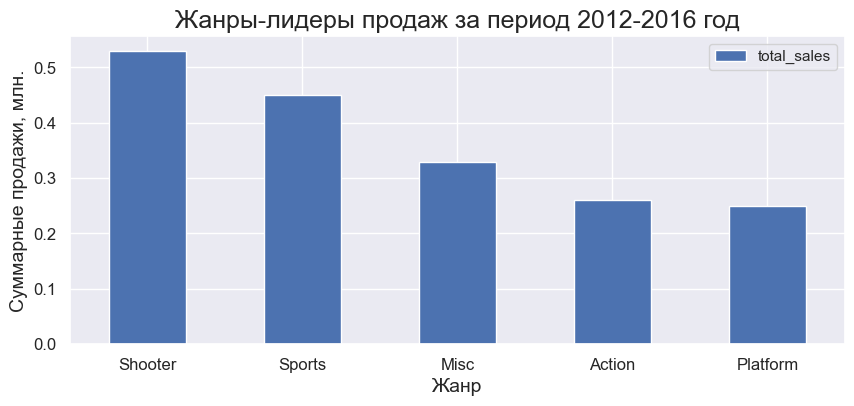

In [220]:
# Прибыльные жанры:
(actual_df
 .pivot_table(index='genre',values='total_sales',aggfunc='median')
 .sort_values(by='total_sales', ascending = False)
 .head(5)
 .plot.bar(figsize=(10,4), 
               rot=30, 
               grid=True)    
)

plt_design(title='Жанры-лидеры продаж за период 2012-2016 год', 
           xlabel='Жанр',
           ylabel='Суммарные продажи, млн.');

Портрет пользователя в различных регионах:
- в Северной Америке типичный пользователь предпочитает  игры на платформе X360, жанра Action, с рейтингом M;
- в Европе: платформа – PS4, жанр – Action, рейтинг – M;
- в Японии: платформа – 3DS, жанр – Role-Playing, рейтинг – E (также рейтинг T не сильно отличается по показателям продаж);


Обе выдвинутые гипотезы статистически подтвердились:
- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые (p_value=0,55);
- Средние пользовательские рейтинги жанров – Action и Sports – разные (p-value=5,2e-20).